<a href="https://colab.research.google.com/github/elder-storck/Disciplina-Seguranca-em-Computacao/blob/main/T3_Redes_Neurais_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠🤖 Treinamento de Redes LSTM para Classificação

- **Deadline**: 24/02/2026
- **Entrega**: O trabalho deve ser entregue via sistema Testr.
- **Pontuação**: 20% da nota do semestre
- O trabalho deve ser realizado individualmente.



## Especificação


### Contexto

O trabalho consiste em realizar o treinamento de redes LSTM usando a base de dados [BBC News Archive disponível no kaggle](https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive?select=bbc-news-data.csv). Esta base de dados contém 2.225 textos publicados no site de notícias da BBC news entre 2004-2005. Cada notícia foi classificada como sendo de um dos seguintes assuntos: business (negócios), entertainment (entretenimento), politics (política), sport (esportes), tech (tecnologia).

O objetivo do trabalho é treinar uma rede neural capaz de identificar o tema de um texto.


### Implementação

- Use o notebook de classificação de sentimentos como ponto de partida.
- use a biblioteca `kagglehub` para fazer o download do dataset no colab.
- Um dos modelos de *word embeddings* disponíveis na biblioteca `gensim` deve ser utilizado para mapear palavras em vetores.
- Use o tipo `nn.LSTM` disponível no `pytorch` (não é necessário implementar a camada LSTM do zero).
- Os dados devem ser divididos em treino, validação e teste. Use o conjunto de validação para ajustar hiperparâmetros e para selecionar o modelo com melhor generalização. Avalie o modelo resultante usando o conjunto de teste apenas ao final.
- Você pode optar por cortar os textos em um tamanho máximo (e.g., 100 palavras), como fizemos no notebook, para que os testes não demorem muito.
- Use o ambiente de `GPU` do colab para evitar que o treinamento demore excessivamente.
- Durante o desenvolvimento, é uma boa idéia usar um subconjunto (e.g., 10%) das notícias para que os testes sejam mais rápidos. Quando tudo estiver correto, faça o treinamento com a base completa.
- Deve ser plotado o gráfico mostrando a evolução da função de perda nos conjuntos de treino e validação.
- Devem ser mostradas as métricas geradas pela função `classification_report` da biblioteca scikit-learn e a matriz de confusão para o conjunto de teste.
- Faça alguns testes qualitativos com textos escritos com você (não use textos da base de dados).
- Discuta brevemente os resultados quantitativos e qualitativos (1-2 parágrafos, no máximo).


# Preparação do Dataset
* Use o notebook de classificação de sentimentos como ponto de partida.
* use a biblioteca kagglehub para fazer o download do dataset no colab.
* Um dos modelos de word embeddings disponíveis na biblioteca gensim deve ser utilizado para mapear palavras em vetores.


In [123]:
# - use a biblioteca `kagglehub` para fazer o download do dataset no colab.
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hgultekin/bbcnewsarchive")

print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'bbcnewsarchive' dataset.
Path to dataset files: /kaggle/input/bbcnewsarchive
['bbc-news-data.csv']


In [124]:
import os
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()   # ativa barras de progresso em operações do pandas

data = pd.read_csv(os.path.join(path, 'bbc-news-data.csv'), sep=None, engine='python')

# Embaralha as linhas do data frame.
data = data.sample(frac=1, random_state=42)

data

,category,filename,title,content
414,business,415.txt,UK house prices dip in November,"UK house prices dipped slightly in November, ..."
420,business,421.txt,LSE 'sets date for takeover deal',The London Stock Exchange (LSE) is planning t...
1644,sport,332.txt,Harinordoquy suffers France axe,Number eight Imanol Harinordoquy has been dro...
416,business,417.txt,Barclays shares up on merger talk,Shares in UK banking group Barclays have rise...
1232,politics,337.txt,Campaign 'cold calls' questioned,Labour and the Conservatives are still teleph...
...,...,...,...,...
1638,sport,326.txt,Robinson answers critics,England captain Jason Robinson has rubbished ...
1095,politics,200.txt,Mallon wades into NE vote battle,Middlesbrough mayor Ray Mallon has been draft...
1130,politics,235.txt,Lib Dems' new election PR chief,The Lib Dems have appointed a senior figure f...
1294,politics,399.txt,Tories reject rethink on axed MP,Sacked MP Howard Flight's local Conservative ...


In [125]:
!pip install gensim

In [126]:
import gensim.downloader

# Vamos utilizar a biblioteca gensim para transformar palavras em *word embeddings*.
# glove = gensim.downloader.load('glove-twitter-50')
glove = gensim.downloader.load('glove-wiki-gigaword-50')


# glove.most_similar('awesome')

In [127]:
print("government" in glove)
print("parliament" in glove)
print("investment" in glove)
print("cybersecurity" in glove)
print("championship" in glove)


True
True
True
True
True


In [128]:
data['content'].iloc[2]

' Number eight Imanol Harinordoquy has been dropped from France\'s squad for the Six Nations match with Ireland in Dublin on 12 March.  Harinordoquy was a second-half replacement in last Saturday\'s 24-18 defeat to Wales. Bourgoin lock Pascal Pape, who has recovered from a sprained ankle, returns to the 22-man squad. Wing Cedric Heymans and Ludovic Valbon come in for Aurelien Rougerie and Jean-Philippe Grandclaude.  Rougerie hurt his chest against Wales while Grandclaude was a second-half replacement against both England and Wales. Valbon, capped in last June\'s Tests against the United States and Canada, was a second half replacement in the win over Scotland.  France coach Bernard Laporte said Harinordoquy had been axed after a poor display last weekend. "Imanol has been dropped from the squad because the least I can say is that he didn\'t make a thundering comeback against Wales," said Laporte. "We know the Ireland game will be fast and rough and we also want to be able to replace bo

A célula abaixo realiza o pré-processamento de um texto passado como argumento, incluindo a conversão das palavras em *word embeddings*.
No pré-processamento está incluso a remoção de tags htmls e outras váriações não desejadas dos textos.

In [129]:
import re
import torch
import numpy as np
from textwrap import fill


max_seq_length = 100

def preprocessing(text):
    # remove tags html
    text = re.sub(r"<.*?>", "", text)
    # remove valores não alfanuméricos
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    # converte para minusculo
    text = text.lower()
    # separa palavras
    words = text.split()
    # trunca a sequencia em um tamanho máximo
    words = words[:max_seq_length]
    # converte as palavras em word embeddings descartando
    # aquelas que não existem e converte o resultado em um torch.tensor
    embds = torch.tensor(np.array([glove[w] for w in words if w in glove]))
    return embds


text = data['content'].iloc[10]
embds = preprocessing(text)

print("text:\n", fill(text))
print("\nembds.shape:", embds.shape)

text:
  Yukos has said a US bankruptcy court will decide whether to block
Russia's impending auction of its main production arm on Thursday.
The Russian oil firm has filed for bankruptcy protection in the US in
an attempt to halt the forced sale. However, Judge Letitia Clark said
the hearing would continue on Thursday when arguments in the case
would be heard. Russian authorities are due to auction off
Yuganskneftegas on 19 December to pay a huge tax bill sent to Yukos.
Russian prosecutors are forcing the sale of the firm's most lucrative
asset Yuganskneftegas to help pay a $27bn (£14bn) back tax bill, which
they claim is owed by Yukos.  Filing for bankruptcy protection in the
US was "a last resort to preserve the rights of our shareholders,
employees and customers," said Yukos chief executive Steven Theede.
The company added it had opted to take action through American courts
as US bankruptcy law gives worldwide jurisdiction over a debtor
company's property and because it was seeking 

In [130]:
print(type(data))


<class 'pandas.core.frame.DataFrame'>


In [131]:
# sizes = [len(preprocessing(t)) for t in data['content']]
# print("Min size:", min(sizes))
# print("Quantos são zero:", sum(1 for s in sizes if s == 0))


Min size: 86
Quantos são zero: 0


In [132]:
# A seguir vamos aplicar o pré-processamento para todas as linhas do dataset.
x = [preprocessing(t) for t in data['content']]

print("Num de amostras:", len(x))
print("Tamanho de uma amostra:", x[-9].shape)

Num de amostras: 2225
Tamanho de uma amostra: torch.Size([99, 50])


In [133]:
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder

# convertendo os labels em inteiros.
encoder = LabelEncoder()
y = encoder.fit_transform(data['category'].to_numpy())
y = y.astype(np.int64)
y = torch.tensor(y)
y

tensor([0, 0, 3,  ..., 2, 2, 1])

In [134]:
from torch.nn.utils.rnn import pad_sequence

# Aplicando padding
x_padded = pad_sequence(x, batch_first=True)
x_padded.shape

torch.Size([2225, 100, 50])

In [135]:
x_padded[-9]

tensor([[ 0.6279, -0.4847, -0.0621,  ..., -0.8761, -0.8917,  1.2679],
        [ 1.2160, -0.3236, -0.2062,  ..., -0.6647, -0.6105,  0.9921],
        [ 0.5482,  0.0388,  0.1013,  ...,  0.2659, -0.4027, -0.1711],
        ...,
        [-0.6668,  0.6354, -0.1330,  ..., -1.1615, -0.0166,  1.0980],
        [-0.4851,  0.2265, -0.0576,  ..., -0.6904, -0.3121,  0.7475],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

A célula abaixo divide os dados em conjutos de treino. Se desejar executar o treino e avaliação mais rapidamente, descomente as linhas que fazem subamostragem, compreendendo que é esperada uma queda de desempenho.

- Os dados devem ser divididos em treino, validação e teste. Use o conjunto de validação para ajustar hiperparâmetros e para selecionar o modelo com melhor generalização. Avalie o modelo resultante usando o conjunto de teste apenas ao final.


In [136]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

#########################################
# Descomente para realizar subamostragem
# sub_x = x_padded[:5000]
# sub_y = y[:5000]
# #
# Descomente para executar com o dataset completo.
sub_x = x_padded
sub_y = y
#########################################

# x_train, x_test, y_train, y_test = train_test_split(
#     sub_x, sub_y,
#     test_size=0.2,
#     random_state=42,
# )

# Primeiro divide em treino (70%) e temp (30%)
x_train, x_temp, y_train, y_temp = train_test_split(
    sub_x, sub_y,
    test_size=0.3,
    random_state=42,
)

# Agora divide o temp em validação (15%) e teste (15%)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size=0.5,  # metade de 30% → 15%
    random_state=42,
)

# Datasets
train_ds = TensorDataset(x_train, y_train)
val_ds   = TensorDataset(x_val, y_val)
test_ds  = TensorDataset(x_test, y_test)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

print("Train size:", len(train_ds))
print("Val size:", len(val_ds))
print("Test size:", len(test_ds))

Train size: 1557
Val size: 334
Test size: 334


# Definição do Modelo

A célula abaixo define o modelo de classificação usando uma camada LSTM seguida de uma camada totalmente conectada com 5 neurônios, um para cada::
business (negócios), entertainment (entretenimento), politics (política), sport (esportes), tech (tecnologia).



In [144]:
from torch import nn

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        hidden_size = 64

        self.lstm = nn.LSTM(
            input_size=50,     # embedding size
            hidden_size=hidden_size,
            bidirectional=False,
            batch_first=True,
        )

        self.dropout = nn.Dropout(p=0.5)

        self.fc = nn.Linear(hidden_size, 5)

    def forward(self, sequence):
        _, (hidden, cell) = self.lstm(sequence)
        # hidden tem shape [seq_length=1, batch_size, hidden_size].
        # O squeeze abaixo remove a primeira dimensão de forma que
        # o shape se torna [batch_size, hidden_size].
        dropped = self.dropout(hidden.squeeze(0))
        prediction = self.fc(dropped)
        return prediction

net = Model()
net(x_padded[:3])

tensor([[-0.0326, -0.1286, -0.0519,  0.0686,  0.0292],
        [-0.0164, -0.1546, -0.0289,  0.1249,  0.0132],
        [-0.1337, -0.1274, -0.0556,  0.0434,  0.0750]],
       grad_fn=<AddmmBackward0>)

# Treinamento e Avaliação

A célula abaixo realiza o treinamento do modelo.

Por simplicidade, utilizamos o conjunto de teste para avaliar a generalização do modelo ao longo do treinamento. **Em aplicações reais, o correto seria utilizar um conjunto independente de validação**.

In [147]:
import torch.optim as optim

net = Model()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=1e-3)
optimizer = optim.Adam(net.parameters(), lr=3e-4)

history = []
n_epochs = 20

# repete por um número de épocas
for epoch in range(n_epochs):
    running_loss = 0.0

    # epoca de treinamento: itera sobre os batches do conjunto de treino
    net.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_loss /= len(train_loader)

    # avaliação no conjunto de teste
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    history.append([running_loss, val_loss])

    if epoch % max(1, n_epochs // 20)  == 0:
        print(f'[{epoch + 1}] loss: {running_loss:.4f} val loss: {val_loss:.4f}')

print('Finished Training')

[1] loss: 1.6086 val loss: 1.5912
[2] loss: 1.5900 val loss: 1.5698
[3] loss: 1.5686 val loss: 1.5404
[4] loss: 1.5282 val loss: 1.4761
[5] loss: 1.3916 val loss: 1.2171
[6] loss: 1.3313 val loss: 1.2291
[7] loss: 1.1809 val loss: 1.0355
[8] loss: 0.9812 val loss: 0.8699
[9] loss: 0.9444 val loss: 0.8895
[10] loss: 0.8464 val loss: 0.7256
[11] loss: 0.7459 val loss: 0.6632
[12] loss: 0.6818 val loss: 0.6460
[13] loss: 0.7621 val loss: 0.9097
[14] loss: 0.8738 val loss: 0.5855
[15] loss: 0.6255 val loss: 0.5359
[16] loss: 0.6076 val loss: 0.5222
[17] loss: 0.5202 val loss: 0.4813
[18] loss: 0.4961 val loss: 0.4886
[19] loss: 0.4707 val loss: 0.4116
[20] loss: 0.4759 val loss: 0.4653
Finished Training


Plota a evolução da função de perda nos conjuntos de treino e validation ao longo do treinamento.

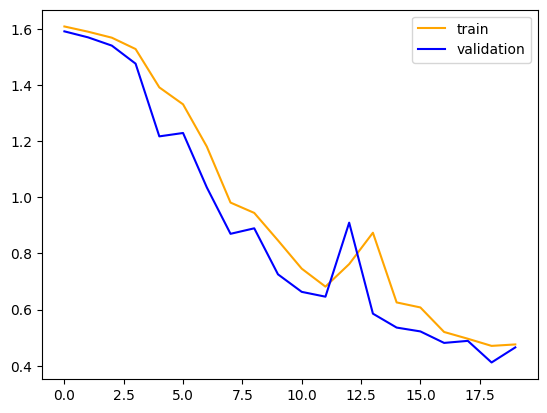

In [149]:
import matplotlib.pyplot as plt

history = np.array(history)

plt.plot(history[:, 0], '-', color='orange', label='train')
plt.plot(history[:, 1], '-', color='blue', label='validation')
plt.legend()

A célula abaixo mostra métricas para o conjunto de teste ao final do treinamento.

In [150]:
print(encoder.classes_)

['business' 'entertainment' 'politics' 'sport' 'tech']


In [151]:
from sklearn.metrics import classification_report

all_labels = []
preds = []

net.eval()

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        cls = np.argmax(outputs, axis=-1)
        all_labels += list(labels)
        preds += list(cls)

print(classification_report(all_labels, preds, target_names=encoder.classes_))

               precision    recall  f1-score   support

     business       0.89      0.89      0.89        66
entertainment       0.92      0.95      0.94        64
     politics       0.92      0.82      0.87        60
        sport       0.96      0.99      0.97        77
         tech       0.93      0.97      0.95        67

     accuracy                           0.93       334
    macro avg       0.93      0.92      0.92       334
 weighted avg       0.93      0.93      0.93       334



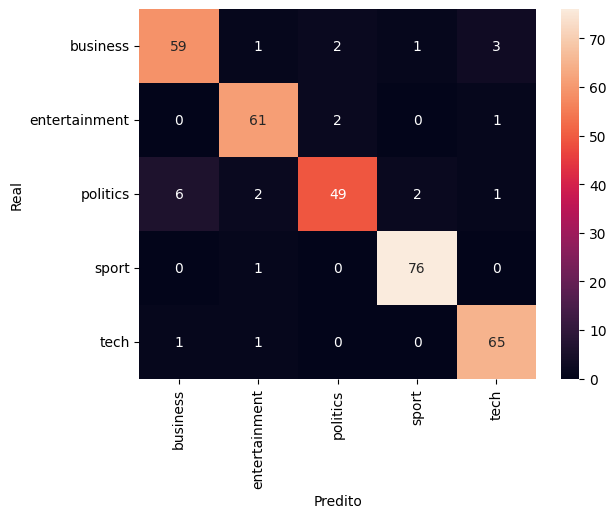

In [152]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, preds)

plt.figure()
sns.heatmap(cm,
            annot=True,
            fmt="d",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

A seguir, realizamos uma análise qualitativa de diferentes frases.

In [156]:

softmax = torch.nn.Softmax(dim=-1)
net.eval()

def avalia_sentenca(texto):
    embds = preprocessing(texto)

    # functional.pad pads last dims
    # first → for (seq_len, feat_dim) you
    # pad (0,0) on feat dim, then (0, pad_len) on seq dim
    # padded = torch.nn.functional.pad(embds, (0, 0, 0, max_seq_length - len(embds)), value=0.0)
    pad_len = max_seq_length - len(embds)
    padded = torch.nn.functional.pad(embds, (0, 0, pad_len, 0), value=0.0)

    # print("len embds:", len(embds))

    with torch.no_grad():
        padded = torch.unsqueeze(padded, 0)
        logits = net(padded)
        probs = softmax(logits)
        probs = np.squeeze(probs)
        cls = np.argmax(probs)

    print(f"* Frase: {texto}\nProbs: {probs} Class: {encoder.classes_[cls]}.\n")


avalia_sentenca("The company reported a significant increase in quarterly profits.")
avalia_sentenca("Investors reacted positively to the new financial strategy.")
avalia_sentenca("The stock market closed higher after strong earnings reports.")
avalia_sentenca("The merger is expected to expand the company's global presence.")

avalia_sentenca("The film received standing ovations at the international festival.")
avalia_sentenca("The actor delivered a brilliant performance in the new drama.")
avalia_sentenca("The series finale disappointed many loyal fans.")
avalia_sentenca("The soundtrack perfectly matches the emotional tone of the movie.")

avalia_sentenca("The government introduced a new tax reform proposal.")
avalia_sentenca("Parliament debated the policy for several hours.")
avalia_sentenca("The president addressed the nation regarding the economic crisis.")
avalia_sentenca("Lawmakers approved the new healthcare legislation.")

avalia_sentenca("The team secured a dramatic victory in the final minutes.")
avalia_sentenca("The player scored a hat-trick during the championship match.")
avalia_sentenca("The coach emphasized the importance of teamwork.")
avalia_sentenca("The athlete broke the world record in the 100-meter race.")

avalia_sentenca("The company unveiled its latest smartphone with advanced AI features.")
avalia_sentenca("Researchers developed a new machine learning algorithm.")
avalia_sentenca("The software update improved system performance and security.")
avalia_sentenca("Cybersecurity experts warned about a new type of malware.")


* Frase: The company reported a significant increase in quarterly profits.
Probs: tensor([0.8040, 0.0147, 0.1189, 0.0081, 0.0544]) Class: business.

* Frase: Investors reacted positively to the new financial strategy.
Probs: tensor([0.5666, 0.0298, 0.3246, 0.0171, 0.0620]) Class: business.

* Frase: The stock market closed higher after strong earnings reports.
Probs: tensor([0.8275, 0.0086, 0.1212, 0.0066, 0.0362]) Class: business.

* Frase: The merger is expected to expand the company's global presence.
Probs: tensor([0.7558, 0.0129, 0.1714, 0.0075, 0.0524]) Class: business.

* Frase: The film received standing ovations at the international festival.
Probs: tensor([0.0179, 0.7832, 0.0904, 0.0616, 0.0469]) Class: entertainment.

* Frase: The actor delivered a brilliant performance in the new drama.
Probs: tensor([0.0117, 0.8352, 0.0632, 0.0447, 0.0452]) Class: entertainment.

* Frase: The series finale disappointed many loyal fans.
Probs: tensor([0.0207, 0.5465, 0.1570, 0.1987, 0.0772]

#Conclusão
O modelo LSTM apresentou excelente desempenho quantitativo, alcançando aproximadamente **93% de acurácia** no conjunto de teste, com valores elevados de precisão, recall e F1-score em praticamente todas as classes. As métricas indicam bom equilíbrio entre as categorias, especialmente para *sport*, *tech* e *entertainment*, que obtiveram resultados próximos ou superiores a 0.95 de F1-score. A classe *politics* apresentou leve redução no recall em comparação às demais, mas ainda manteve desempenho consistente. De modo geral, os resultados quantitativos mostram que o modelo conseguiu aprender padrões relevantes do dataset e generalizar bem para dados não vistos.

Nos testes qualitativos com frases escritas manualmente, o modelo demonstrou boa capacidade de identificar corretamente o tema central dos textos. Notícias claramente relacionadas a esporte, tecnologia ou entretenimento foram classificadas com alta confiança. Observou-se alguma ambiguidade entre as classes *business* e *politics*, especialmente em frases envolvendo políticas econômicas ou reformas governamentais, o que é esperado devido à sobreposição semântica entre esses temas. Ainda assim, o comportamento do modelo foi coerente e compatível com o contexto das sentenças analisadas.



### Pontos Extras

Receberá um ponto extra, o aluno que:
- Utilizar um LLM baseado em Transformer pré-treinado (e.g., [BERT](https://medium.com/@davidlfliang/intro-getting-started-with-text-embeddings-using-bert-9f8c3b98dee6)) para mapear as notícias em *embeddings*.
- Utilizar uma rede Multilayer Perceptron para classificar os *embeddings*.
- Comparar a performance desta solução com a LSTM.

⚠️**IMPORTANTE**⚠️
- Não é necessário (nem recomendável considerando o prazo) tentar realizar *fine-tuning* do LLM pré-treinado.
- Estes modelos são SUPER-ULTRA-MASTER-BLASTER lentos na CPU. Use o ambiente de GPU do colab para evitar ficar 20h esperando para transformar os textos em *embeddings*.
- Salve os embeddings depois da geração para evitar ter que gerá-los novamente. Quando necessário, faça upload do arquivo novamente para o colab.